# 1_business_data_understanding_suto

**Purpose:** In this notebook, we want to experiment different approaches to this regression problem:
- separating the training dataset in two or more groups according to SalePrice, and creating a regression to each part; and
- separating the training dataset in groups according to a clustering method, and creating a regression to each part.

**Methodology:**

**Results:** Describe and comment the most important results.

---

**Suggested next steps**

- [ ] Do the following approaches:
    - [ ] Classification + Regressions
    - [ ] Clustering (try to use DBSCAN) + Regressions
    - [ ] Reducing dimensionality (PCA or t-SNE) + Regressions
- [ ] How to cluster categorical attributes?
- [ ] Separate the categorical attributes relating to SalePrice (teste de hipótese / ANOVA).


# Setup

## Library import
We import all the required Python libraries

In [8]:
%matplotlib inline

import os
import pickle
from typing import List

# Data manipulation
from feature_engine.encoding import OneHotEncoder, CountFrequencyEncoder, RareLabelEncoder
from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns

from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report, mean_absolute_error, mean_squared_error
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

os.chdir('../')
from src.utils.data_describe import breve_descricao, serie_nulos, cardinalidade
os.chdir('./notebooks/')

# Options for pandas
# pd.options.display.max_columns = None
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.options.display.max_rows = 120

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [221]:
RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
REPORTS_FOLDER = '../reports/'
PROCESSED_FOLDER = '../data/processed/'
MODELS_FOLDER = '../models/'
RANDOM_STATE = 42


## Data import
We retrieve all the required data for the analysis.

In [175]:
df = pd.read_csv(RAW_FOLDER + 'train.csv', index_col=0)
df_evaluation = df.copy()

df_test = pd.read_csv(RAW_FOLDER + 'test.csv', index_col=0)

df_evaluation.shape

(1460, 80)

# Data prep

## Presence of null values

In [4]:
lst_columns_null = serie_nulos(df_evaluation, corte=0.5).index.tolist()
lst_columns_null

4 atributos/features/campos possuem mais de 0.5 de valores nulos.


['PoolQC', 'MiscFeature', 'Alley', 'Fence']

# Clustering the data before modeling

## 1st approach: Classification into two groups and creating regressions for each group

count      1460.0
mean     180921.0
std       79443.0
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

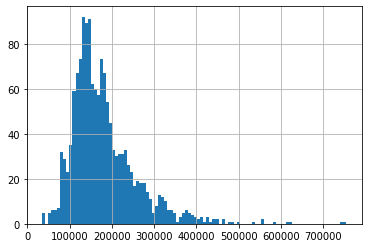

In [6]:
df_evaluation = df.copy()

df_evaluation['SalePrice'].hist(bins=100);
round(df_evaluation['SalePrice'].describe())

### Splitting data into train, validation and test

In [7]:
X = df_evaluation.drop(columns=['SalePrice'])
y = df_evaluation[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

### Creating the classification model

In [8]:
df_evaluation_clf = pd.concat([X_train, y_train], axis=1)
df_evaluation_clf['price_group'] = np.where(df_evaluation_clf['SalePrice'] > 214000, 1, 0)

print(df_evaluation_clf['price_group'].value_counts())
df_evaluation_clf.head()

0    874
1    294
Name: price_group, dtype: int64


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,price_group
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1957.0,RFn,1,294,TA,TA,Y,250,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000,0
1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000,0
639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,None,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,P,328,0,164,0,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000,0
800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,TA,Y,0,0,264,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000,0
381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,None,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,TA,Y,0,0,242,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000,0


In [9]:
X_clf = df_evaluation_clf.drop(columns=['SalePrice', 'price_group'])
y_clf = df_evaluation_clf[['SalePrice', 'price_group']]

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=RANDOM_STATE)

lst_columns_to_use = X_train_clf.select_dtypes(include=[int, 'int64', float, 'float64']).columns.tolist()
X_train_clf = X_train_clf[lst_columns_to_use].copy()
X_test_clf = X_test_clf[lst_columns_to_use].copy()

dataprep_model = MeanMedianImputer(imputation_method='median', variables=X_train_clf.columns.tolist())

X_train_clf_transformed = dataprep_model.fit_transform(X_train_clf)
X_test_clf_transformed = dataprep_model.transform(X_test_clf)

In [10]:
model_clf = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)
model_clf.fit(X_train_clf_transformed, y_train_clf['price_group'])
y_pred_clf = model_clf.predict(X_test_clf_transformed)
y_pred_clf = pd.DataFrame(y_pred_clf, index=X_test_clf_transformed.index, columns=['price_group'])

print(classification_report(y_test_clf['price_group'], y_pred_clf))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       171
           1       0.89      0.79      0.84        63

    accuracy                           0.92       234
   macro avg       0.91      0.88      0.89       234
weighted avg       0.92      0.92      0.92       234



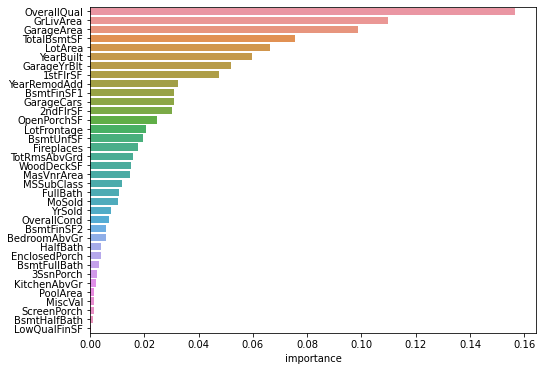

In [108]:
df_importance = pd.DataFrame(
    model_clf.feature_importances_, index=model.feature_names_in_, columns=['importance']
).sort_values(by='importance', ascending=False)


a4_dims = (8, 6)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(data=df_importance, y=df_importance.index, x='importance', ax=ax);

### Creating the regression models

In [11]:
X_train_after_clf = pd.concat([X_train_clf_transformed, y_train_clf['price_group']], axis=1)
X_test_after_clf = pd.concat([X_test_clf_transformed, y_pred_clf], axis=1)

model_rg_0 = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
model_rg_0.fit(
    X_train_after_clf[X_train_after_clf['price_group']==0],
    y_train_clf.loc[X_train_after_clf[X_train_after_clf['price_group']==0].index, 'SalePrice']
)

y_pred_rg_0 = model_rg_0.predict(X_test_after_clf[X_test_after_clf['price_group']==0])

print(f"""
MAE: {mean_absolute_error(y_test_clf.loc[X_test_after_clf[X_test_after_clf['price_group']==0].index, 'SalePrice'], y_pred_rg_0)}
RMSE: {mean_squared_error(y_test_clf.loc[X_test_after_clf[X_test_after_clf['price_group']==0].index, 'SalePrice'], y_pred_rg_0)**0.5}""")


MAE: 14581.020449438203
RMSE: 22206.45240950226


In [12]:
model_rg_1 = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
model_rg_1.fit(
    X_train_after_clf[X_train_after_clf['price_group']==1],
    y_train_clf.loc[X_train_after_clf[X_train_after_clf['price_group']==1].index, 'SalePrice']
)

y_pred_rg_1 = model_rg_1.predict(X_test_after_clf[X_test_after_clf['price_group']==1])

print(f"""
MAE: {mean_absolute_error(y_test_clf.loc[X_test_after_clf[X_test_after_clf['price_group']==1].index, 'SalePrice'], y_pred_rg_1)}
RMSE: {mean_squared_error(y_test_clf.loc[X_test_after_clf[X_test_after_clf['price_group']==1].index, 'SalePrice'], y_pred_rg_1)**0.5}""")


MAE: 31669.75553571429
RMSE: 43367.647151957826


## 2nd approach: Clustering data before regression

count      1460.0
mean     180921.0
std       79443.0
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

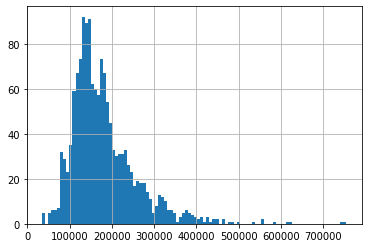

In [35]:
df_evaluation = df.select_dtypes(exclude='object').copy()

df_evaluation['SalePrice'].hist(bins=100);
round(df_evaluation['SalePrice'].describe())

In [36]:
X = df_evaluation.drop(columns=['SalePrice'])
y = df_evaluation[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

In [37]:
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_train, y_train, test_size=0.20, random_state=RANDOM_STATE)

In [38]:
lst_columns_to_use = X_train_agg.select_dtypes(include=[int, 'int64', float, 'float64']).columns.tolist()
dataprep_model = MeanMedianImputer(imputation_method='median', variables=lst_columns_to_use)
X_train_agg_transformed = dataprep_model.fit_transform(X_train_agg[lst_columns_to_use])
X_test_agg_transformed = dataprep_model.transform(X_test_agg[lst_columns_to_use])

### Scaling data

In [39]:
lst_columns_to_use = X_train_agg.select_dtypes(include=[int, 'int64', float, 'float64']).columns.tolist()
dataprep_model = MeanMedianImputer(imputation_method='median', variables=lst_columns_to_use)
X_train_agg_transformed = dataprep_model.fit_transform(X_train_agg[lst_columns_to_use])
X_test_agg_transformed = dataprep_model.transform(X_test_agg[lst_columns_to_use])

In [40]:
scaling = MinMaxScaler()
X_train_agg_transformed = scaling.fit_transform(X_train_agg_transformed)

In [41]:
model = DBSCAN(eps=0.1, min_samples=3, n_jobs=-1, )
groups = model.fit(X_train_agg_transformed)
print(len(groups.labels_))

934


In [43]:
X_train_agg_transformed

array([[0.58823529, 0.07876712, 0.01531099, ..., 0.        , 1.        ,
        0.25      ],
       [1.        , 0.18493151, 0.04747203, ..., 0.        , 0.27272727,
        1.        ],
       [0.58823529, 0.16780822, 0.00804143, ..., 0.        , 0.36363636,
        0.        ],
       ...,
       [0.        , 0.16780822, 0.02780117, ..., 0.        , 0.27272727,
        0.25      ],
       [0.23529412, 0.20205479, 0.03874761, ..., 0.        , 0.54545455,
        0.25      ],
       [0.        , 0.23287671, 0.05490532, ..., 0.        , 0.36363636,
        1.        ]])

In [38]:
len(X_train_agg_transformed)

934

## 3rd approach

count      1460.0
mean     180921.0
std       79443.0
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

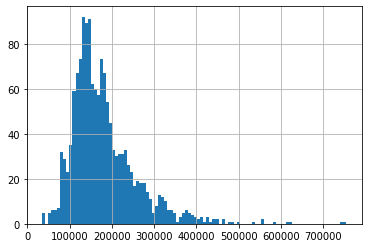

In [186]:
lst_columns_subset = df.select_dtypes(exclude='object').columns.tolist()
df_evaluation = df[lst_columns_subset].copy()

df_evaluation['SalePrice'].hist(bins=100);
round(df_evaluation['SalePrice'].describe())

In [178]:
X = df_evaluation.drop(columns=['SalePrice'])
y = df_evaluation[['SalePrice']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_train, y_train, test_size=0.20, random_state=RANDOM_STATE)

### Preprocessing data

#### Inputing data in null positions

In [179]:
lst_columns_to_use = X_train_agg.select_dtypes(include=[int, 'int64', float, 'float64']).columns.tolist()

dataprep_model = MeanMedianImputer(imputation_method='median', variables=lst_columns_to_use)
X_train_agg_transformed = dataprep_model.fit_transform(X_train_agg[lst_columns_to_use])
X_test_agg_transformed = dataprep_model.transform(X_test_agg[lst_columns_to_use])

#### Scaling the data

In [180]:
scaling = MinMaxScaler()
X_train_agg_transformed = scaling.fit_transform(X_train_agg_transformed)
X_test_agg_transformed = scaling.transform(X_test_agg_transformed)

X_train_agg_transformed = pd.DataFrame(X_train_agg_transformed, columns=X_train_agg.columns, index=X_train_agg.index).copy()
X_test_agg_transformed = pd.DataFrame(X_test_agg_transformed, columns=X_test_agg.columns, index=X_test_agg.index)

In [181]:
agg_model = KMeans(n_clusters=3, random_state=RANDOM_STATE)
groups = agg_model.fit(X_train_agg_transformed)

X_train_agg_transformed['group'] = groups.labels_

X_test_agg_transformed['group'] = agg_model.predict(X_test_agg_transformed)

X_train_agg_transformed.head()

print(f"""Qty of items per group:
{X_train_agg_transformed['group'].value_counts()}""")

Qty of items per group:
0    399
1    290
2    245
Name: group, dtype: int64


### Creating the regression models

In [204]:
dct_result = {}

for group in set(groups.labels_):
    # training dataset
    X_train_agg_transformed_temp = X_train_agg_transformed.loc[X_train_agg_transformed['group']==group].copy()
    y_train_agg_temp = y_train_agg.loc[X_train_agg_transformed_temp.index].copy()
    
    # validation dataset
    X_test_agg_transformed_temp = X_test_agg_transformed.loc[X_test_agg_transformed['group']==group].copy()
    y_test_agg_temp = y_test_agg.loc[X_test_agg_transformed_temp.index].copy()
    
    model_rg = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE)
    model_rg.fit(
        X_train_agg_transformed_temp,
        y_train_agg_temp.iloc[:, 0].values
    )
    
    model_name = 'regression_model_group_'
    extension = '.pkl'
    
    pickle.dump(model_rg, open(MODELS_FOLDER + f'{model_name}{str(group)}{extension}', 'wb'))

    y_pred_rg = model_rg.predict(X_test_agg_transformed_temp)
    
    dct_result[f'group_{group}'] = {
        'qtd_registries': len(y_pred_rg),
        'MAE': mean_absolute_error(y_test_agg_temp.values, y_pred_rg),
        'RMSE': mean_squared_error(y_test_agg_temp.values, y_pred_rg)**0.5}
    
df_result = pd.DataFrame.from_dict(dct_result, orient='index')

df_result

,qtd_registries,MAE,RMSE
group_0,100,12448.554200,17330.914151
group_1,70,24084.283429,35204.046536
group_2,64,22114.547344,32402.880486


In [183]:
(df_result['RMSE']*df_result['qtd_registries']).sum()/df_result['qtd_registries'].sum()

26799.82488748356

### Testing dataset

In [201]:
try:
    lst_columns_subset.remove('SalePrice')
except Exception:
    pass

df_test_evaluation = df_test[lst_columns_subset].copy()

df_test_evaluation = dataprep_model.transform(df_test_evaluation)
df_test_evaluation = scaling.transform(df_test_evaluation)

df_test_evaluation = pd.DataFrame(df_test_evaluation, columns=lst_columns_subset, index=df_test.index)

df_test_evaluation['group'] = agg_model.predict(df_test_evaluation)

In [219]:
df_y_pred = pd.DataFrame()

for group in df_test_evaluation['group'].unique():
    
    model = pickle.load(open(MODELS_FOLDER + f'{model_name}{group}{extension}', 'rb'))
    y_pred = model.predict(df_test_evaluation[df_test_evaluation['group']==group])
    y_pred = pd.DataFrame(y_pred, index=df_test_evaluation[df_test_evaluation['group']==group].index, columns=['SalePrice'])
    df_y_pred = pd.concat([
        df_y_pred, y_pred
    ], axis=0)

len(df_y_pred)

1459

In [223]:
df_y_pred.to_csv(PROCESSED_FOLDER + 'y_pred_kaggle_clustering_experiment.csv')